In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import pymc3 as pm
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
sns.set()
import japanize_matplotlib 

# 線形回帰モデル

## データ作成

In [2]:
np.random.seed(1)
N=100
alpha_real=2.5
beta_real=0.9
eps_real=np.random.normal(0,0.5,size=N)

x=np.random.normal(10,1,N)
y_real=alpha_real+beta_real*x
y=y_real+eps_real




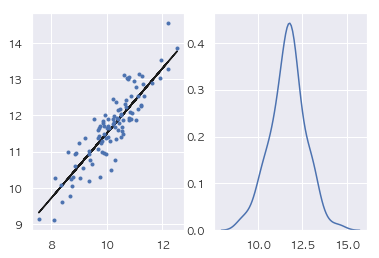

In [3]:
plt.subplot(1,2,1)
plt.plot(x,y_real,'k')
plt.plot(x,y,'b.')

plt.subplot(1,2,2)
sns.kdeplot(y)

## 線形モデルをMCMCでサンプリング

In [4]:
with pm.Model() as model:
    alpha=pm.Normal('alpha',mu=0,sd=10)
    beta=pm.Normal('beta',mu=0,sd=1)
    eps=pm.HalfCauchy('eps',5)
    
    # 決定的な変数を規程
    mu=pm.Deterministic('mu',alpha+beta*x)
    
    y_pred=pm.Normal('y_pred',mu=mu,sd=eps,observed=y)
    
    start=pm.find_MAP()
    step=pm.Metropolis()
    trace=pm.sample(1000,step,start)

logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 1792.12it/s]         
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2645.33draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121e62080>,
      dtype=object)

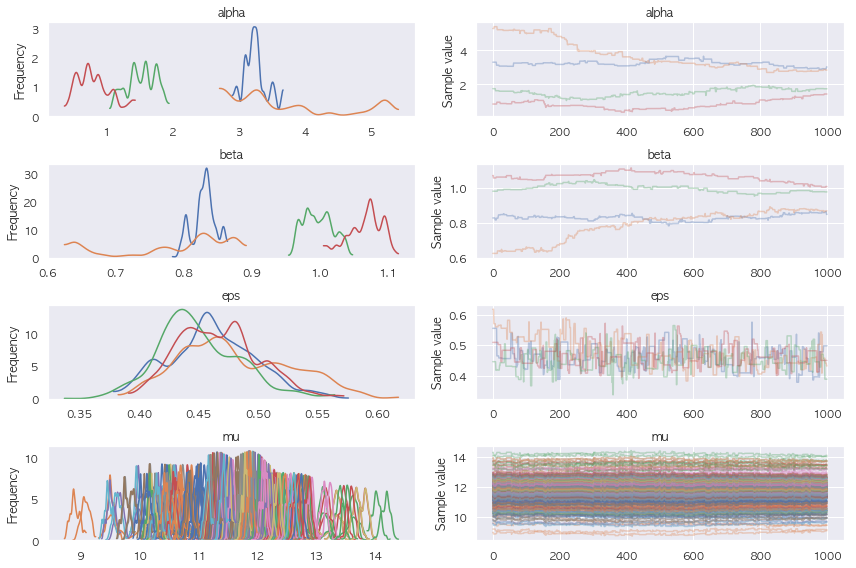

In [5]:
pm.traceplot(trace)

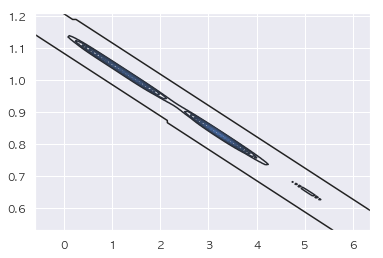

In [6]:
sns.kdeplot(trace['alpha'],trace['beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12358e048>,
      dtype=object)

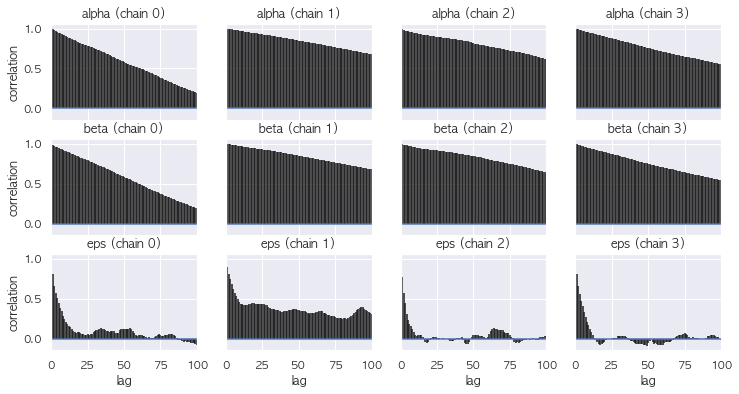

In [7]:
pm.autocorrplot(trace,['alpha','beta','eps'])

明らかにパラメータ同士に相関関係を持っていしまっている

## 標準化を行う

In [8]:
x_=(x-x.mean())/x.std()
y_=(y-y.mean())/y.std()

In [9]:
with pm.Model() as model:
    alpha=pm.Normal('alpha',mu=0,sd=10)
    beta=pm.Normal('beta',mu=0,sd=1)
    eps=pm.HalfCauchy('eps',5)
    
    # 決定的な変数を規程
    mu=pm.Deterministic('mu',alpha+beta*x_)
    
    y_pred=pm.Normal('y_pred',mu=mu,sd=eps,observed=y_)
    
    start=pm.find_MAP()
    step=pm.Metropolis()
    trace=pm.sample(1000,step,start)

logp = -68.267, ||grad|| = 0.084558: 100%|██████████| 14/14 [00:00<00:00, 1788.94it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4067.67draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124386198>,
      dtype=object)

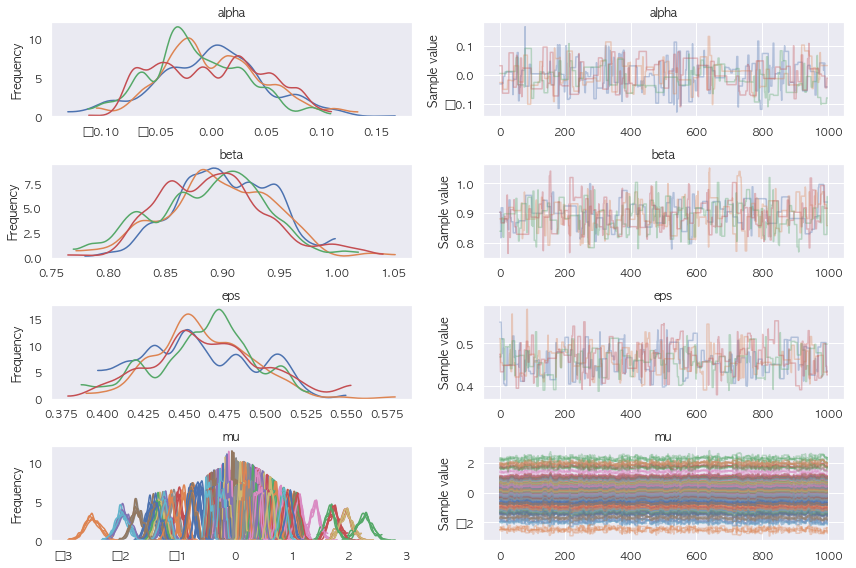

In [10]:
pm.traceplot(trace)

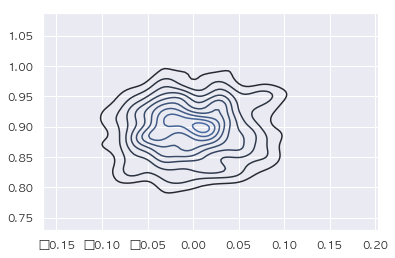

In [11]:
sns.kdeplot(trace['alpha'],trace['beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1227ac1d0>,
      dtype=object)

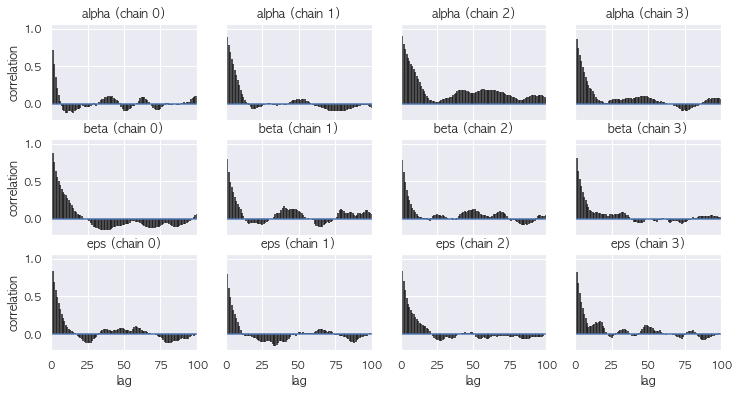

In [12]:
pm.autocorrplot(trace,['alpha','beta','eps'])

## 標準化せずに、サンプリングアルゴリズムを変更する

In [13]:
with pm.Model() as model:
    alpha=pm.Normal('alpha',mu=0,sd=10)
    beta=pm.Normal('beta',mu=0,sd=1)
    eps=pm.HalfCauchy('eps',5)
    
    # 決定的な変数を規程
    mu=pm.Deterministic('mu',alpha+beta*x)
    
    y_pred=pm.Normal('y_pred',mu=mu,sd=eps,observed=y)
    
    start=pm.find_MAP()
    step=pm.NUTS()
    trace=pm.sample(1000,step,start)

logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 2199.97it/s]         
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:10<00:00, 561.24draws/s]
The acceptance probability does not match the target. It is 0.894466522260789, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125b8d5f8>,
      dtype=object)

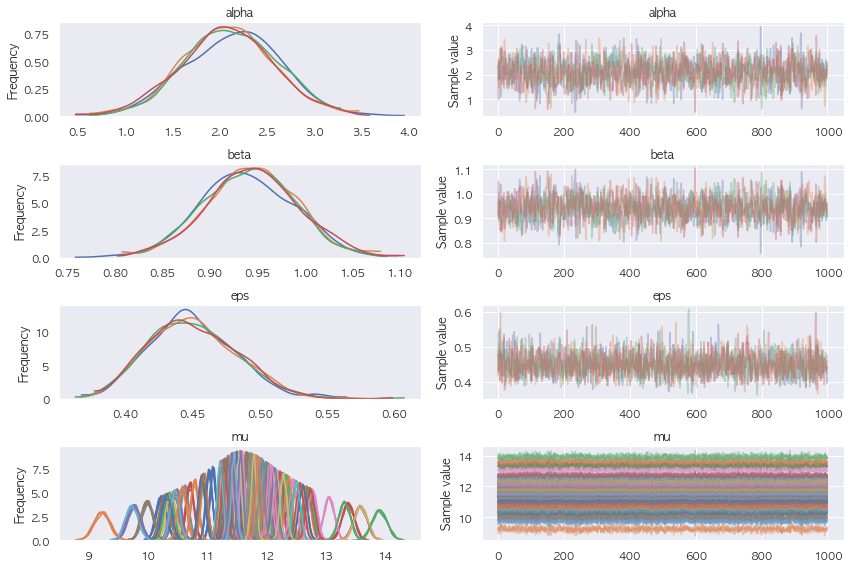

In [14]:
pm.traceplot(trace)

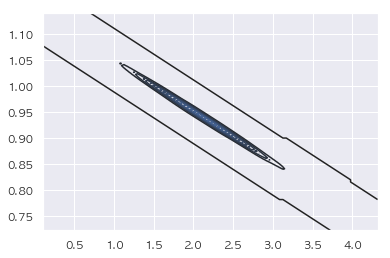

In [15]:
sns.kdeplot(trace['alpha'],trace['beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125339e80>,
      dtype=object)

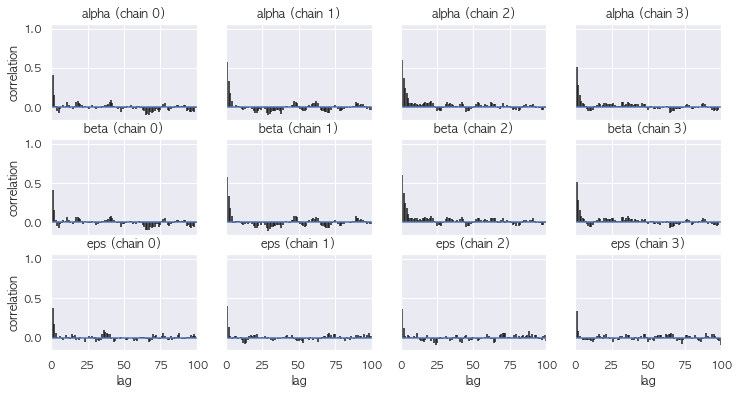

In [16]:
pm.autocorrplot(trace,['alpha','beta','eps'])

## 可視化

### 平均と10個サンプリングしてきたもの

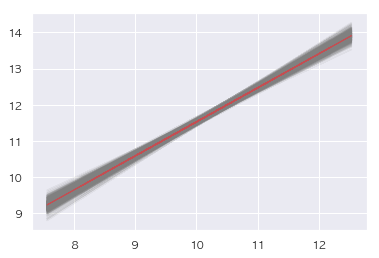

In [17]:
alpha_m=trace['alpha'].mean()
beta_m=trace['beta'].mean()

idx=range(0,len(trace['alpha']),10)
plt.plot(x,trace['alpha'][idx]+trace['beta'][idx]*x[:,np.newaxis],c='gray',alpha=0.1)
plt.plot(x,alpha_m+beta_m*x,c='r',lw=1)

## 90%HPDと50%HPDを可視化

In [18]:
ppc=pm.sample_ppc(trace,samples=1000,model=model)

100%|██████████| 1000/1000 [00:00<00:00, 1258.44it/s]


In [19]:
idx=np.argsort(x)
x_ord=x[idx]

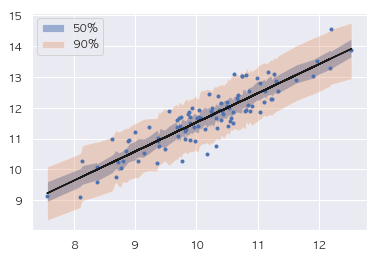

In [20]:
plt.plot(x,y,'b.')
plt.plot(x,alpha_m+beta_m*x,c='k')

sig0=pm.hpd(ppc['y_pred'],alpha=0.5)[idx]
sig1=pm.hpd(ppc['y_pred'],alpha=0.05)[idx]
plt.fill_between(x_ord,sig0[:,0],sig0[:,1],alpha=0.5,label='50%')
plt.fill_between(x_ord,sig1[:,0],sig1[:,1],alpha=0.3,label='90%')
plt.legend(loc='upper left')

# 多変量正規分布

## 可視化

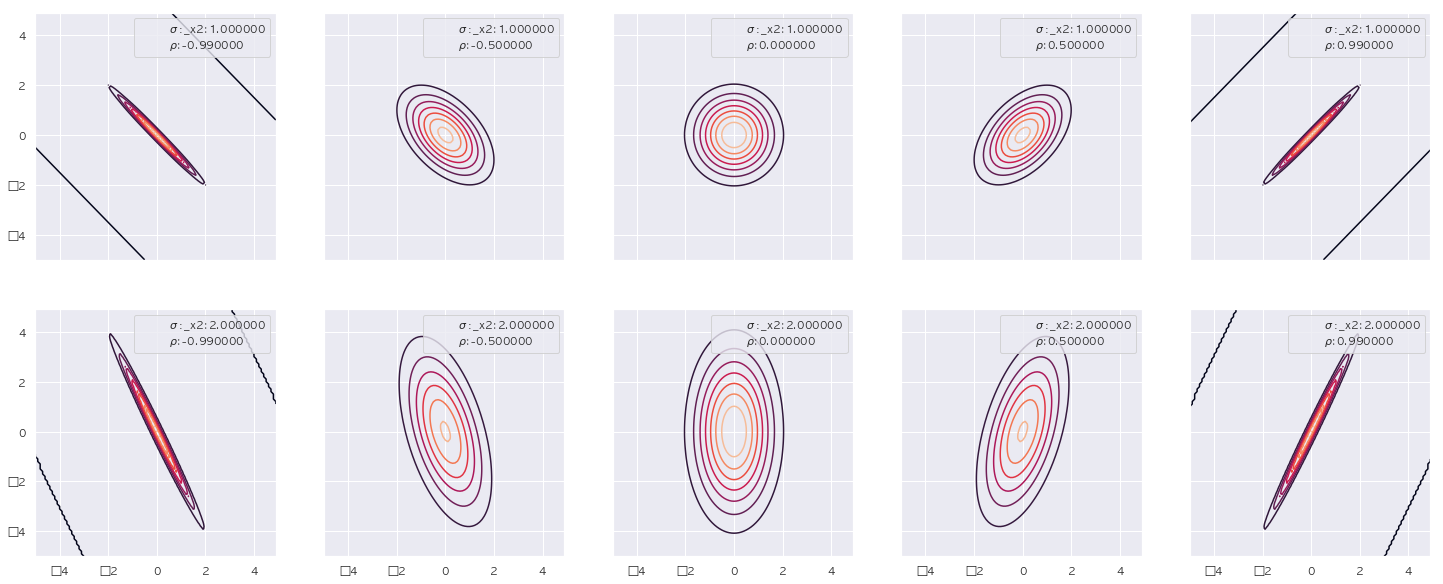

In [21]:
sigma_x1=1
sigmas_x2=[1,2]
# ピアソンの相関係数
rhos = [-0.99, -0.5, 0, 0.5, 0.99]
# 座標点
k,l=np.mgrid[-5:5:.1,-5:5:.1]
pos=np.empty(k.shape+(2,))
pos[:,:,0]=k
pos[:,:,1]=l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True,figsize=(25,10))
for i in range(2):
    for j in range(5):
        sigma_x2=sigmas_x2[i]
        rho=rhos[j]
        # 共分散行列
        cov=[[sigma_x1**2,sigma_x1*sigma_x2*rho],
            [sigma_x1*sigma_x2*rho,sigma_x2**2]]
        # 多変量正規分布を定義
        rv=stats.multivariate_normal([0,0],cov)
        
        ax[i,j].contour(k,l,rv.pdf(pos))
        ax[i,j].plot(0,label=f'$\sigma:$_x2:{sigma_x2:2f}\n$\\rho$:{rho:2f}',alpha=0)
        ax[i,j].legend()
    

In [22]:
k.shape

(100, 100)

## 階層線形回帰

In [115]:
# グループごとの観測数
N=20
# グループ数
M=8
idx=np.repeat(range(M-1),N)
# 最後だけ、一つしか観測値がないのとする
idx=np.append(idx,7)
np.random.seed(314)

# 真の値
alpha_real=np.random.normal(2.5,0.5,size=M)
beta_real=np.random.beta(6,1,size=M)
eps_real=np.random.normal(0,0.5,size=len(idx))

# 観測値
x_m=np.random.normal(10,1,len(idx))
y_m=np.zeros(len(idx))
y_m=alpha_real[idx]+beta_real[idx]*x_m+eps_real

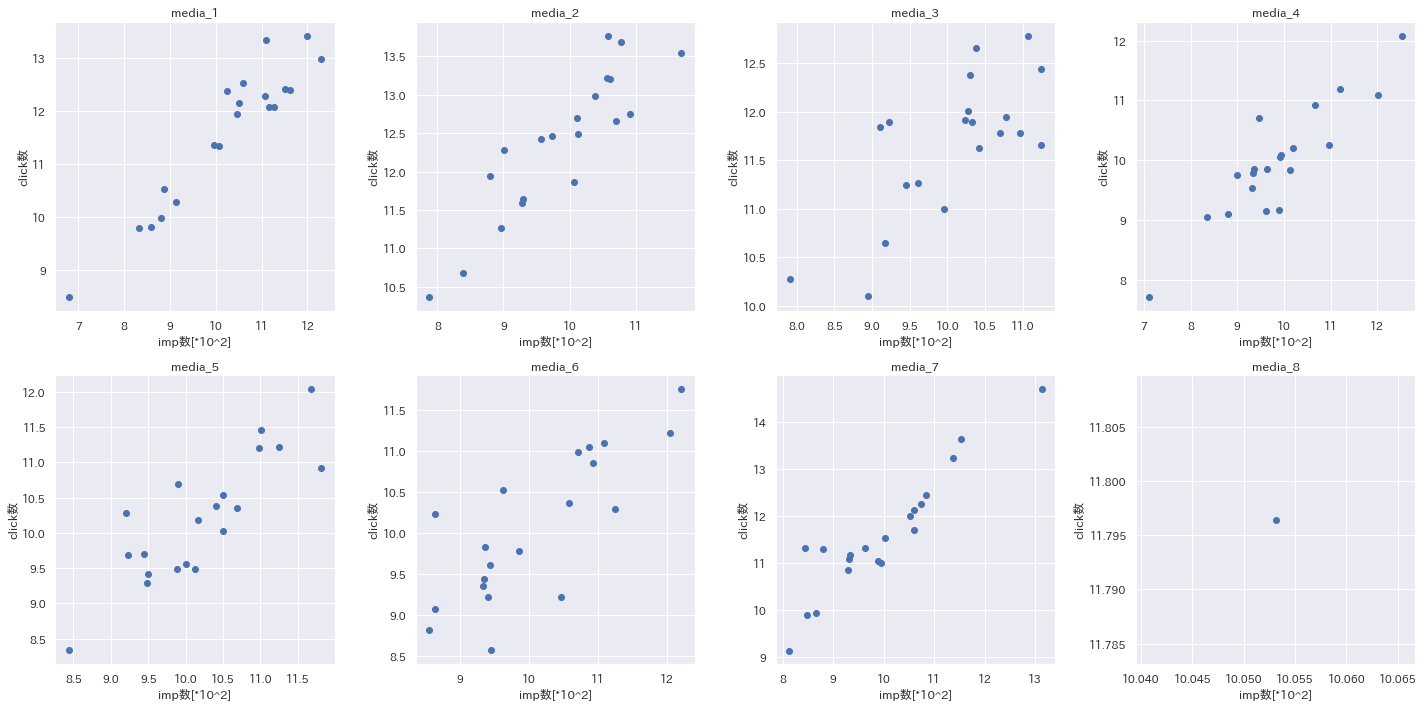

In [116]:
plt.figure(figsize=(20,10))
j,k=0,N

for i in range(M):
    ax=plt.subplot(2,4,i+1)
    ax.scatter(x_m[j:k],y_m[j:k])
    ax.set_title(f'media_{i+1}')
    ax.set_xlabel(f'imp数[*10^2]')
    ax.set_ylabel(f'click数')
    j+=N
    k+=N
plt.tight_layout()


## モデル構築

In [49]:
x_centered=x_m-x_m.mean()

In [78]:
with pm.Model() as hierarchical_model:
    # hyper paramter
    alpha_tmp_mu=pm.Normal('alpha_tmp_mu',mu=0,sd=10)
    alpha_tmp_sd=pm.HalfNormal('alpha_tmp_sd',sd=10)
    beta_mu=pm.Normal('beta_mu',mu=0,sd=10)
    beta_sd=pm.HalfNormal('beta_sd',sd=10)
    
    # 事前分布
    alpha_tmp=pm.Normal('alpha_tmp',mu=alpha_tmp_mu,sd=alpha_tmp_sd,shape=M)
    beta=pm.Normal('beta',mu=beta_mu,sd=beta_sd,shape=M)
    epsilon=pm.HalfCauchy('epsilon',5)
    nu=pm.Exponential('nu',1/30)
    
    # 尤度
    y_pred=pm.StudentT('y_pred',mu=alpha_tmp[idx]+beta[idx]*x_centered,
                      sd=epsilon,nu=nu,observed=y_m)
   
    # 元のscaleに戻す
    alpha=pm.Deterministic('alpha',alpha_tmp-beta*x_m.mean())
    alpha_mu=pm.Deterministic('alpha_mu',alpha_tmp_mu-beta_mu*x_m.mean())
    alpha_sd=pm.Deterministic('alpha_sd',alpha_tmp_sd-beta_sd*x_m.mean())
    
    # サンプリング
    start=pm.find_MAP()
    step = pm.NUTS()
    trace_hm = pm.sample(1000, step=step,start=start,njobs=1)

logp = -374.53, ||grad|| = 65,162: 100%|██████████| 287/287 [00:00<00:00, 1158.28it/s]        
Sequential sampling (2 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
100%|██████████| 1500/1500 [01:57<00:00, 17.35it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9036306658738904, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9406143959774238, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133d0aeb8>,
      dtype=object)

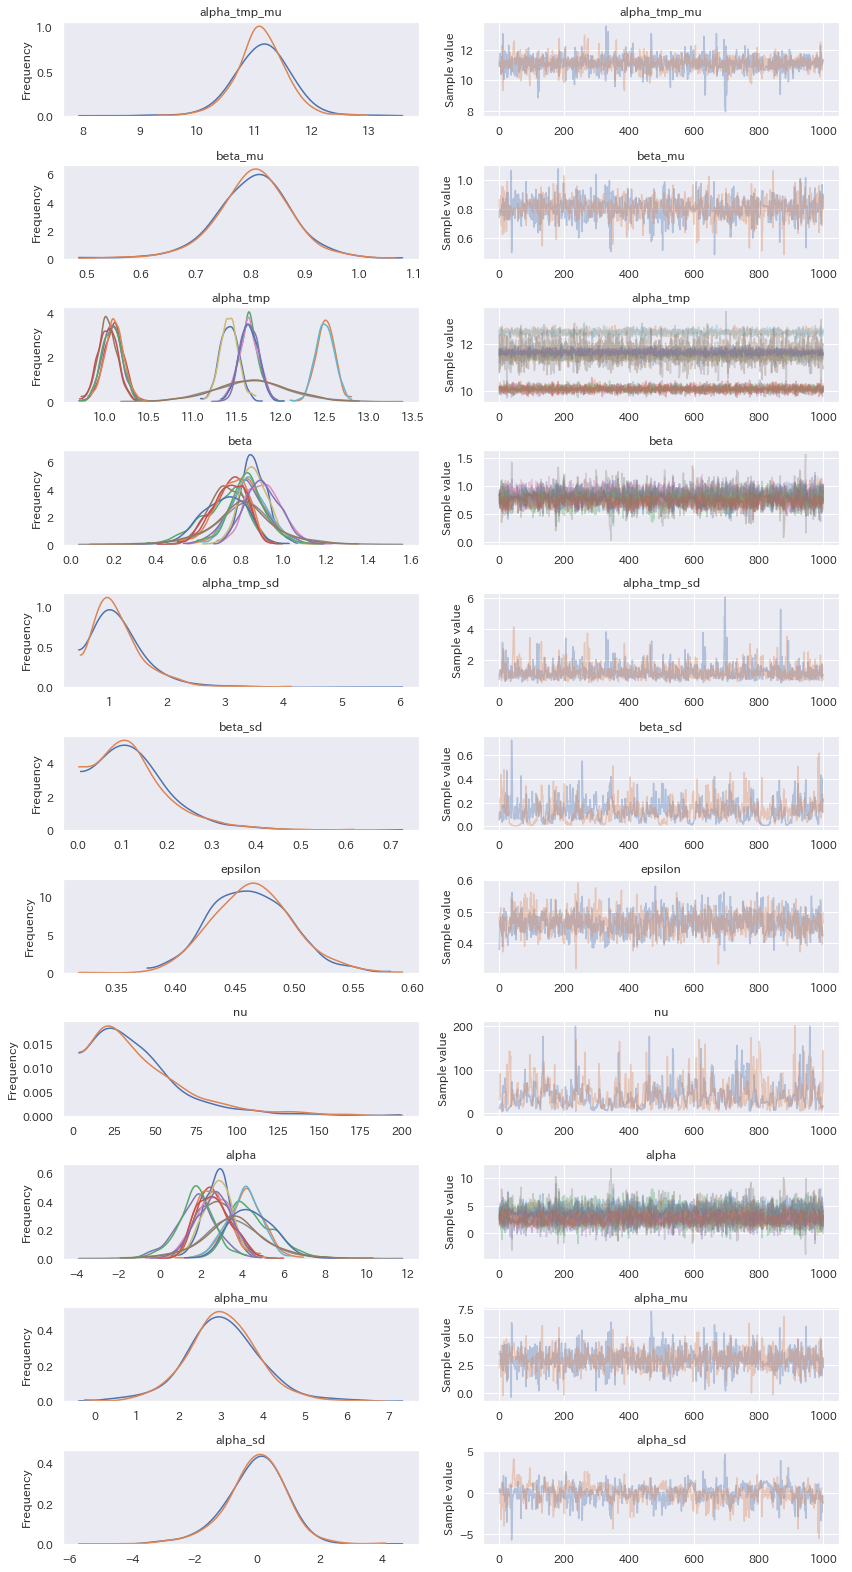

In [79]:
pm.traceplot(trace_hm)

In [81]:
pm.summary(trace_hm)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp_mu,11.119073,0.488799,0.013842,10.191128,12.052080,1242.059942,0.999636
beta_mu,0.804545,0.071749,0.001901,0.658564,0.952154,1220.421529,0.999500
alpha_tmp__0,11.413634,0.105123,0.002237,11.200592,11.616078,2010.342660,0.999561
alpha_tmp__1,12.501812,0.106091,0.002147,12.290103,12.696806,1860.571422,1.000500
alpha_tmp__2,11.634571,0.108106,0.002559,11.420807,11.845533,2159.397504,0.999618
alpha_tmp__3,10.105189,0.111768,0.002636,9.876147,10.318708,2071.063884,0.999648
alpha_tmp__4,10.079602,0.109996,0.002407,9.873290,10.301398,2232.172614,0.999540
alpha_tmp__5,10.033699,0.108893,0.002470,9.825464,10.255302,1678.000243,0.999736
alpha_tmp__6,11.638168,0.108672,0.002464,11.429179,11.849749,1946.348302,1.001042
alpha_tmp__7,11.664601,0.418820,0.009129,10.834827,12.493452,1837.899650,0.999785


array([<matplotlib.axes._subplots.AxesSubplot object at 0x129fe49e8>,
      dtype=object)

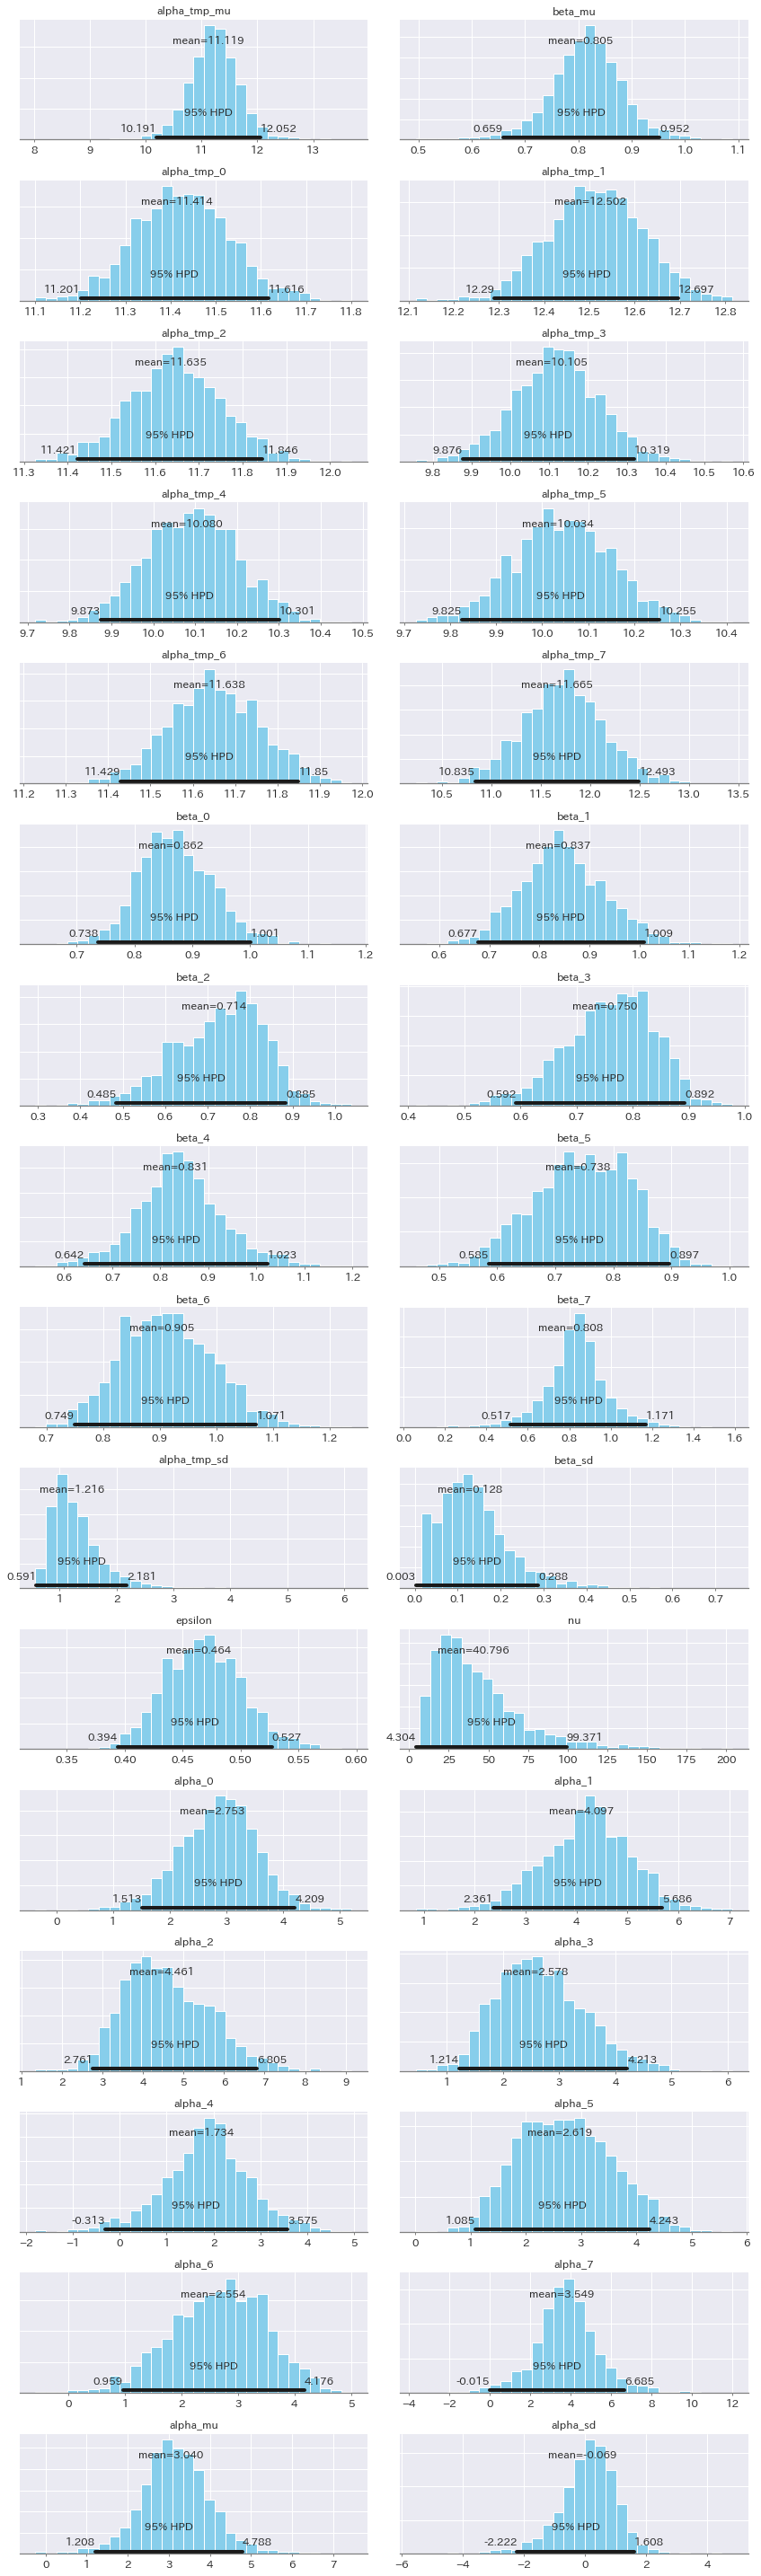

In [113]:
pm.plot_posterior(trace_hm)

In [117]:
beta_real

array([0.89177808, 0.96075013, 0.87574597, 0.78793584, 0.7775104 ,
       0.70400598, 0.92485907, 0.93568724])

## 線形性をそれぞれ可視化

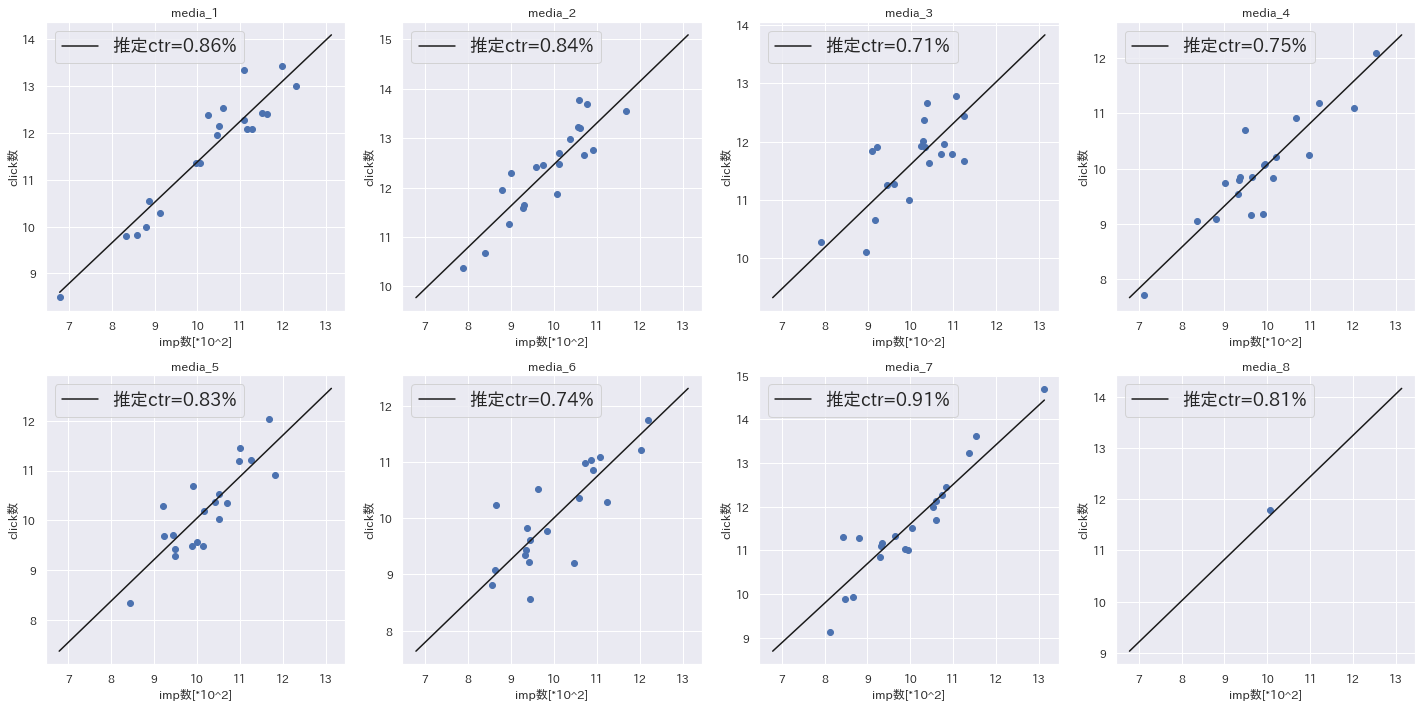

In [98]:
plt.figure(figsize=(20,10))
j,k=0,N
chain_hm=trace_hm[100:]
x_range=np.linspace(x_m.min(),x_m.max(),10)
for i in range(M):
    ax=plt.subplot(2,4,i+1)
    ax.scatter(x_m[j:k],y_m[j:k])
    ax.set_title(f'media_{i+1}')
    ax.set_xlabel(f'imp数[*10^2]')
    ax.set_ylabel(f'click数')
    alfa_m=chain_hm['alpha'][:,i].mean()
    beta_m=chain_hm['beta'][:,i].mean()
    ax.plot(x_range,alfa_m+beta_m*x_range,c='k',label=f'推定ctr={beta_m*0.01:.2%}')
    ax.legend(fontsize=18)
    j+=N
    k+=N
plt.tight_layout()


# 多重線形回帰

In [118]:
np.random.seed(314)
# 観測数
N = 100

# 真の値
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

# 観測データ
X=np.array([np.random.normal(i,j,N) for i,j in zip([10,2],[1,1.5])])
X_mean=X.mean(axis=1,keepdims=True)
X_centered=X-X_mean

# 観測データ
y=alpha_real+np.dot(beta_real,X)+eps_real

## それぞれの特徴量の分布を可視化

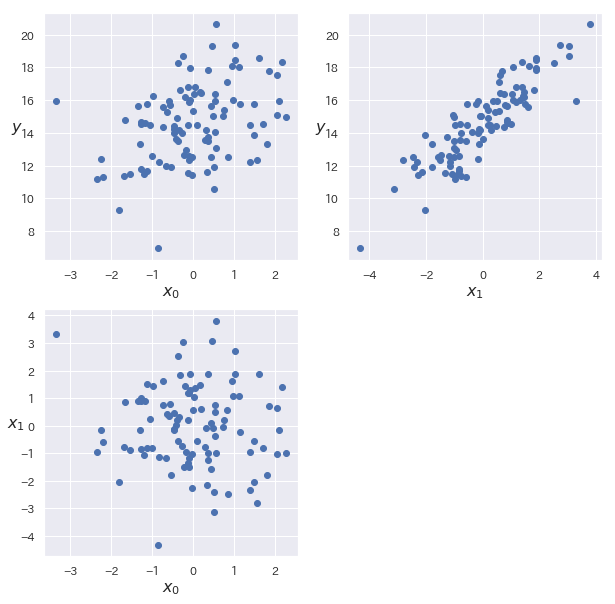

In [119]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)

## モデル構築

In [128]:
with pm.Model() as model_mlr:
    alpha_tmp=pm.Normal('alpha_tmp',mu=0,sd=10)
    # sizeは特徴量の数
    beta=pm.Normal('beta',mu=0,sd=1,shape=2)
    eps=pm.HalfCauchy('eps',5)
    
    mu=alpha_tmp+pm.math.dot(beta,X_centered)
    
    # 基準をもとに戻す
    alpha=pm.Deterministic('alpha',alpha_tmp-pm.math.dot(beta,X_mean))
    
    y_pred=pm.Normal('y_pred',mu=mu,sd=eps,observed=y)
    
    start=pm.find_MAP()
    step=pm.NUTS(scaling=start)
    trace_mlr=pm.sample(1000,start=start,step=step)

logp = -75.778, ||grad|| = 32.757: 100%|██████████| 41/41 [00:00<00:00, 2060.52it/s]   
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha_tmp]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2416.43draws/s]


/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1339a3278>,
      dtype=object)

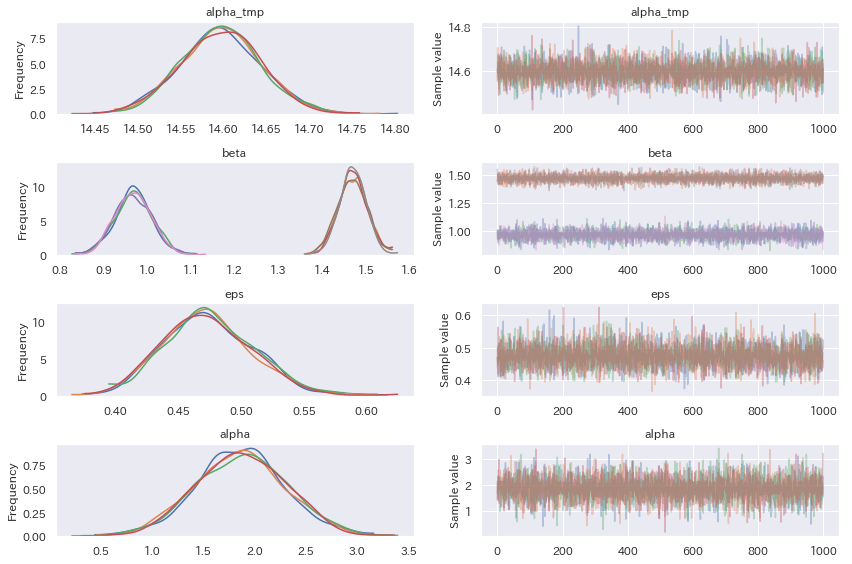

In [129]:
pm.traceplot(trace_mlr)

In [130]:
pm.summary(trace_mlr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,14.596561,0.046422,0.000683,14.501708,14.683496,5969.105938,0.999644
beta__0,0.967979,0.042146,0.000479,0.883076,1.047443,6979.842638,0.999734
beta__1,1.469525,0.032564,0.000461,1.404213,1.532323,5851.807758,1.000022
eps,0.473749,0.035384,0.000528,0.409895,0.544378,5381.150977,1.000590
alpha__0,1.859725,0.439296,0.005042,1.000632,2.716564,6683.681768,0.999811


In [126]:
chain_mlr=trace_mlr[100:]

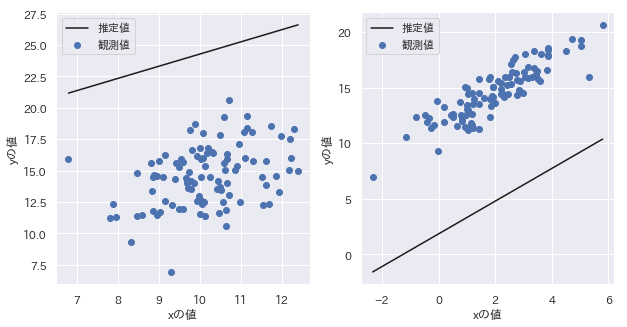

In [156]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
x0_range=np.linspace(X[0,:].min(),X[0,:].max(),10)
x1_range=np.linspace(X[1,:].min(),X[1,:].max(),10)
ax[0].scatter(X[0,:],y,label='観測値')
ax[0].plot(x0_range,chain_mlr['alpha'].mean()+chain_mlr['beta'][:,0].mean()*x0_range,c='k',label='推定値')
ax[0].set_ylabel('yの値')
ax[0].set_xlabel('xの値')
ax[1].scatter(X[1,:],y,label='観測値')
ax[1].plot(x1_range,chain_mlr['alpha'].mean()+chain_mlr['beta'][:,1].mean()*x1_range,c='k',label='推定値')
ax[1].set_ylabel('yの値')
ax[1].set_xlabel('xの値')
ax[0].legend()
ax[1].legend()

alphaの値はそれぞれ定義してないので、切片はずれる